# Классификация возраста, пола и расы по лицу человека

Используйте публичные данные UTKfaces. https://susanqq.github.io/UTKFace/
В работе необходимо использовать данные Aligned&Cropped Faces, где произведены вырезы лиц с исходных изображений.

Изображения хранятся в формате jpg. В имени (почти!!!) каждого иображения имеется информации о человеке

$$[возраст]\_[пол]\_[раса]\_[время].jpg$$

Потребуются первые три параметра из названия каждого файлы.

В текущем файле реализована тренировка сверточной нейронной сети resnet50 для классификации возраста по фотографии. Текущая СНС используется с предобученными весами (transfer learning - перенос обучения) на датасете imagenet. Перенос обучения позволяет использовать веса сети с другого набора данных. Как правило, такой подход позволяет существенно поднять точность предсказания на новом наборе данных.

Задачи:
1. Переписать класс Dataset так, чтобы __getitem__ выдывал классы возраст, пол и раса. Задача регрессии для предсказания возраста является сложно, в этой связи будем решать ее как классификационную. Необходимо закодировать возраст в один из классов [(0, 5), (5, 14), (14, 30), (30, 45), (45, 60), (60, 120)], таким образом __getitem__ будет выдавать номер класса, которому принадлежит человек на фотографии.
Дополнительная задача (по желанию): при классификации ответом является возрастная, а не число. Можно получать возраст в числом выражении если использовать математическое ожидание по ответам нейронной сети. Для этого необходимо умножить ответы в виде Softmax на средние значения возраста в каждой группе и проссумировать все значения. 

2. Переписать класс Net. Добавить Mobilentv2 и Resnet34, так чтобы аргументом net можно было выбрать на основе какого экстрактора признаков построить сеть для классификации. Добавить дополнительные классификаторы для возраста и расы.

3. Обучить сеть. Попробуйте оптимизатор SGD и Adam. Визуализировать результаты на валидационном наборе данных.

Примечание: для тренировки лучше использовать GPU или colab.research.google.com с поддержкой GPU.

In [14]:
import numpy as np
import os
from PIL import Image
import torch
import torchvision
from torchvision import datasets, transforms, models
import matplotlib.pyplot as plt
%matplotlib inline

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


Ниже реализован класс Dataset, который имеет три обязательных метода __init__, __len__, __getitem__.

- __init__ происходит инициализация переменных датасета.
- __len__ возращает количество изображений в датасете.
- __getitem__ возвращает изображение в формате PIL и значения классов age, gender, race по индексу.

Размер изображения установить $224 \times 224$. В случае медленного обучения на процессоре параметр можно уменьшить, но потребуется произвести изменения в месте крепления экстрактора признаков и классификатора нейронной сети.

In [15]:
genders = {
    1:'male', 2:'female'
}
age_groups = { 
    0:'0-5', 1:'5-14', 
    2:'14-30', 3:'30-45', 
    4:'45-60', 5:'60+'
}
races = {
    0:'White', 1:'Black', 
    2:'Asian', 3:'Indian', 4:'Others(Hispanic, Latino, Middle Eastern)'
}

In [16]:
import torch
from torch.utils import data

T = transforms.Compose([
    transforms.Resize([224,224]),
    transforms.ToTensor(),
])

class Dataset(data.Dataset):
    'Characterizes a dataset for PyTorch'
    def __init__(self, path, subset = 'train', test_part = 0.2, transform = None):
        'Initialization'
        self.path = path
        self.subset = subset
        self.transform = transform
        names = [it for it in os.listdir(path) if len(it.split('_')) > 3]
        
        names = [os.path.join(path, it) for it in names]
        np.random.seed(0)
        np.random.shuffle(names)
        if subset == 'train':
            self.ids = names[:int(len(names) * test_part)]
        elif subset == 'valid':
            self.ids = names[int(len(names) * test_part):]
        self.age_list = [(0, 5), (5,14), (14, 30), (30, 45), (45, 60), (60, 120)]

    def __len__(self):
        'Denotes the total number of samples'
        return len(self.ids)
    

    def __getitem__(self, index):
        'Generates one sample of data'
        # Select sample
        ID = self.ids[index]

        image = Image.open(ID)

        # Load data and get label
        age =  int(ID.split('/')[-1].split('_')[0])
        gender = int(ID.split('/')[-1].split('_')[1])
        race = int(ID.split('/')[-1].split('_')[2])
        
        
        if self.transform:
            image = self.transform(image)
        
        for i in range(6):
            age_class = range(self.age_list[i][0],self.age_list[i][1])
            if age in age_class:
                age = i
        
        return image, gender, age, race

In [17]:
path_to_data = '/home/AndreyTatarchenkov/data/UTKFace'
train_data = Dataset(path_to_data, subset='train', test_part = 0.2, transform = T)
valid_data = Dataset(path_to_data, subset='valid', test_part = 0.2, transform = T)

Ниже представлен пример получения изображения по индексу.

person gender male
person age class 30-45
person race Others(Hispanic, Latino, Middle Eastern)


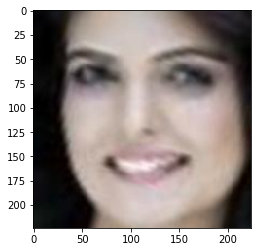

In [18]:
img, gender, age, race = train_data[138]
print('person gender', genders.get(gender))
print('person age class', age_groups.get(age))
print('person race', races.get(race))
plt.imshow(img.numpy().transpose(1,2,0))

Объекты train_data и valid_data передадим в DataLoader. Объект train_loader и valid_loader будут выдавать пачку изображения с правильными ответами (батчи).

In [19]:
train_loader = torch.utils.data.DataLoader(train_data, 
                                           batch_size=16, 
                                           shuffle=True)

# download and transform test dataset
valid_loader = torch.utils.data.DataLoader(valid_data,
                                          batch_size=16, 
                                          shuffle=False)

tensor([1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0])
tensor([2, 3, 0, 1, 3, 4, 5, 0, 5, 3, 2, 3, 4, 5, 4, 2])
tensor([0, 0, 2, 0, 3, 3, 0, 0, 0, 2, 0, 4, 3, 0, 2, 1])


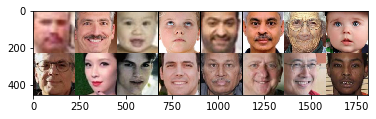

In [20]:
images, genders, ages, races = next(iter(train_loader))
plt.imshow(torchvision.utils.make_grid(images).numpy().transpose(1,2,0))
print(genders)
print(ages)
print(races)

In [21]:
import torch.nn as nn
import torch.nn.functional as F

In [48]:
from torchvision.models import mobilenet_v2, resnet34, resnet50
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self, net='mobilenetv2', pretrained=True):
        super(Net, self).__init__()
        self.net = net
        if self.net == 'mobilenetv2':
            self.model = models.mobilenet_v2(pretrained=True)
            self.model.classifier = nn.Dropout(p=0.2,inplace=False)
            self.model.gender_cls = nn.Linear(62720,2)
            self.model.age_cls = nn.Linear(62720,6)
            self.model.race_cls = nn.Linear(62720,5)
            
        elif self.net == 'resnet34':
            self.model = models.resnet34(pretrained)
            self.model.gender_cls = nn.Linear(512, 2)
            self.model.age_cls = nn.Linear(512, 6)
            self.model.race_cls = nn.Linear(512, 5)
        elif self.net == 'resnet50':
            self.model = models.resnet50(pretrained)
            self.model.gender_cls = nn.Linear(2048, 2)
            self.model.age_cls = nn.Linear(2048, 6)
            self.model.race_cls = nn.Linear(2048, 5)

        #self.model.gender_cls = nn.Linear(2048, 2)

    def forward(self, x):
        if (self.net == 'resnet50') or (self.net == 'resnet34'):
            x = self.model.conv1(x)
            x = self.model.bn1(x)
            x = self.model.relu(x)
            x = self.model.maxpool(x)
            x = self.model.layer1(x)
            x = self.model.layer2(x)
            x = self.model.layer3(x)
            x = self.model.layer4(x)
            x = self.model.avgpool(x)
            x = x.view(x.size(0), -1)
            gender = self.model.gender_cls(x)
            age = self.model.age_cls(x)
            race = self.model.race_cls(x)
            
        if self.net == 'mobilenetv2':
            x = self.model.features(x)
            x = self.model.classifier(x) 
            x = x.view(x.size(0), -1)
            gender = self.model.gender_cls(x)
            age = self.model.age_cls(x)
            race = self.model.race_cls(x)        


        
        return gender, age, race



In [23]:
#import os
#os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
#resnet50 = Net(net='resnet50', pretrained=False).to(device)
#resnet34 = Net(net='resnet34').to(device)
#mobilenetv2 = Net(net='mobilenetv2').to(device)

In [24]:
#import torch.optim as optim

#criterion = nn.CrossEntropyLoss()
#optimizer = optim.SGD(resnet50.parameters(), lr=1e-5, momentum = 0.9)
#model = resnet50

In [31]:
x = list(range(1, 10 + 1))

In [35]:
%%time
from IPython.display import clear_output

def trainWithOptimizer(model):
    loss_list = []
    val_loss_list = []
    accuracy_age_list = []
    v_accuracy_age_list = []
    accuracy_gender_list = []
    v_accuracy_gender_list = []
    accuracy_race_list = []
    v_accuracy_race_list = []
    for epoch in range(10):  # loop over the dataset multiple times

        for phase in ['train', 'valid']:

            if phase == 'train':

                model.train(True)

                running_loss = 0.0
                correct = 0
                total = 0

                gender_correct = 0
                age_correct = 0
                race_correct = 0

                for i, data in enumerate(train_loader):
                    # get the inputs; data is a list of [inputs, labels]
                    inputs, gender, age, race = data[0].to(device), data[1].to(device), data[2].to(device), data[3].to(device)

                    # zero the parameter gradients
                    optimizer.zero_grad()

                    # forward + backward + optimize
                    out_gender, out_age, out_race = model(inputs)

                    loss_gender = criterion(out_gender, gender)
                    loss_age = criterion(out_age, age)
                    loss_race =criterion(out_race, race)

                    loss = loss_gender + loss_age + loss_race

                    loss.backward()
                    optimizer.step()

                    # print statistics
                    running_loss += loss.item()

                    _, gender_pred = torch.max(out_gender.data, 1)
                    _, age_pred = torch.max(out_age.data, 1)
                    _, race_pred = torch.max(out_race.data, 1)

                    total += gender.size(0)

                    gender_correct += (gender_pred == gender).sum().item()
                    age_correct += (age_pred == age).sum().item()
                    race_correct += (race_pred == race).sum().item()


            elif phase == 'valid':

                model.train(False)

                validation_loss = 0.
                v_correct = 0
                v_total = 0

                v_age_correct = 0
                v_gender_correct = 0
                v_race_correct = 0

                for i, v_data in enumerate(valid_loader):
                    v_loss = 0
                    v_loss_age = 0
                    v_loss_gender = 0
                    v_loss_race = 0

                    v_inputs, v_gender, v_age, v_race = v_data[0].to(device), v_data[1].to(device), v_data[2].to(device), v_data[3].to(device)

                    v_out_gender, v_out_age, v_out_race = model(v_inputs)

                    v_loss_gender += criterion(v_out_gender, v_gender)
                    v_loss_age += criterion(v_out_age, v_age)
                    v_loss_race += criterion(v_out_race, v_race)

                    validation_loss += v_loss_age.item() + v_loss_gender.item() + v_loss_race.item()

                    _, v_gender_pred = torch.max(v_out_gender.data, 1)
                    _, v_age_pred = torch.max(v_out_age.data, 1)
                    _, v_race_pred = torch.max(v_out_race.data, 1)

                    v_total += v_gender.size(0)

                    v_gender_correct += (v_gender_pred == v_gender).sum().item()
                    v_age_correct += (v_age_pred == v_age).sum().item()
                    v_race_correct += (v_race_pred == v_race).sum().item()

        print('Epoch %d, loss: %.3f, val_loss: %.3f, acc_gender: %.3f, val_acc_gender: %.3f, acc_age: %.3f, val_acc_age: %3f, acc_race: %3f, val_acc_race: %3f' %
              (epoch + 1, running_loss / len(train_loader), validation_loss / len(valid_loader), 
               gender_correct / total, v_gender_correct / v_total,
               age_correct / total, v_age_correct / v_total,
               race_correct / total, v_race_correct / v_total))
        loss_list.append(running_loss / len(train_loader))
        val_loss_list.append(validation_loss / len(valid_loader))

        accuracy_age_list.append(age_correct / total)
        v_accuracy_age_list.append(v_age_correct / v_total)

        accuracy_gender_list.append(gender_correct / total)
        v_accuracy_gender_list.append(v_gender_correct / v_total)

        accuracy_race_list.append(race_correct / total)
        v_accuracy_race_list.append(v_race_correct / v_total)

    print('Finished Training')
    plt.figure(figsize=(16,8))
    plt.title("training and validation accuracy")
    plt.plot(x, accuracy_age_list, 'm', label = 'accuracy_age')
    plt.plot(x, v_accuracy_age_list, 'm--', label = 'validation_accuracy_age')

    plt.plot(x, accuracy_gender_list, 'c', label = 'accuracy_gender')
    plt.plot(x, v_accuracy_gender_list, 'c--', label = 'validation_accuracy_gender')

    plt.plot(x, accuracy_race_list, 'g', label = 'accuracy_race')
    plt.plot(x, v_accuracy_race_list, 'g--', label = 'validation_accuracy_race')
    plt.xticks(range(0, 11))
    plt.xlabel("epochs")
    plt.ylabel("accuracy")
    plt.legend();

CPU times: user 12 µs, sys: 0 ns, total: 12 µs
Wall time: 14.8 µs


Epoch 1, loss: 3.837, val_loss: 3.698, acc_gender: 0.541, val_acc_gender: 0.607, acc_age: 0.310, val_acc_age: 0.355358, acc_race: 0.395697, val_acc_race: 0.423750
Epoch 2, loss: 3.637, val_loss: 3.600, acc_gender: 0.636, val_acc_gender: 0.689, acc_age: 0.355, val_acc_age: 0.360525, acc_race: 0.431976, val_acc_race: 0.423803
Epoch 3, loss: 3.543, val_loss: 3.514, acc_gender: 0.705, val_acc_gender: 0.738, acc_age: 0.356, val_acc_age: 0.364849, acc_race: 0.432398, val_acc_race: 0.429182
Epoch 4, loss: 3.459, val_loss: 3.435, acc_gender: 0.740, val_acc_gender: 0.759, acc_age: 0.360, val_acc_age: 0.368699, acc_race: 0.436617, val_acc_race: 0.434138
Epoch 5, loss: 3.375, val_loss: 3.347, acc_gender: 0.751, val_acc_gender: 0.770, acc_age: 0.374, val_acc_age: 0.382092, acc_race: 0.444843, val_acc_race: 0.448956
Epoch 6, loss: 3.292, val_loss: 3.275, acc_gender: 0.770, val_acc_gender: 0.780, acc_age: 0.384, val_acc_age: 0.394642, acc_race: 0.463193, val_acc_race: 0.467781
Epoch 7, loss: 3.204, 

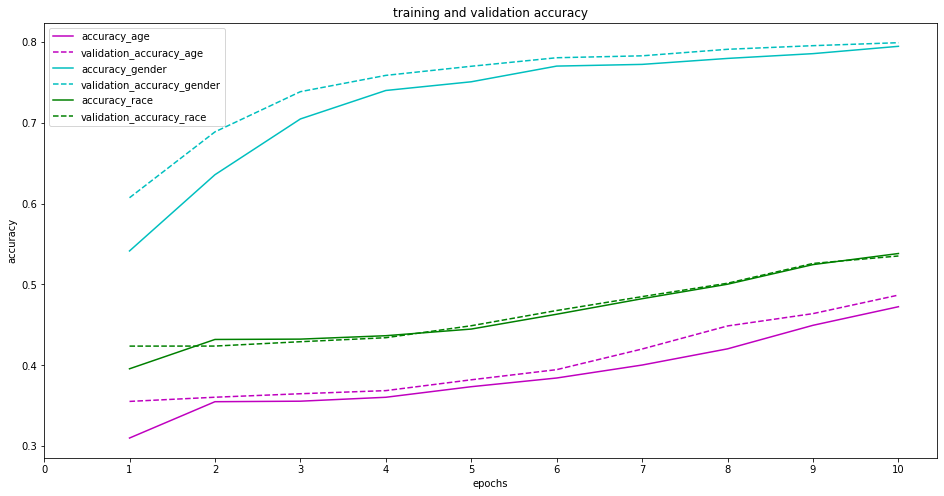

In [37]:
%%time
import os
import torch.optim as optim

os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
resnet50 = Net(net='resnet50', pretrained=False).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(resnet50.parameters(), lr=1e-5, momentum = 0.9)
trainWithOptimizer(resnet50)

Epoch 1, loss: 3.863, val_loss: 3.764, acc_gender: 0.516, val_acc_gender: 0.515, acc_age: 0.351, val_acc_age: 0.356623, acc_race: 0.371652, val_acc_race: 0.423487
Epoch 2, loss: 3.730, val_loss: 3.731, acc_gender: 0.542, val_acc_gender: 0.531, acc_age: 0.350, val_acc_age: 0.356676, acc_race: 0.431555, val_acc_race: 0.425227
Epoch 3, loss: 3.705, val_loss: 3.729, acc_gender: 0.547, val_acc_gender: 0.565, acc_age: 0.352, val_acc_age: 0.358047, acc_race: 0.431133, val_acc_race: 0.423698
Epoch 4, loss: 3.696, val_loss: 3.699, acc_gender: 0.561, val_acc_gender: 0.550, acc_age: 0.351, val_acc_age: 0.356096, acc_race: 0.431344, val_acc_race: 0.428812
Epoch 5, loss: 3.669, val_loss: 3.679, acc_gender: 0.567, val_acc_gender: 0.580, acc_age: 0.350, val_acc_age: 0.359207, acc_race: 0.436195, val_acc_race: 0.435298
Epoch 6, loss: 3.652, val_loss: 3.664, acc_gender: 0.586, val_acc_gender: 0.577, acc_age: 0.354, val_acc_age: 0.361527, acc_race: 0.443155, val_acc_race: 0.439675
Epoch 7, loss: 3.631, 

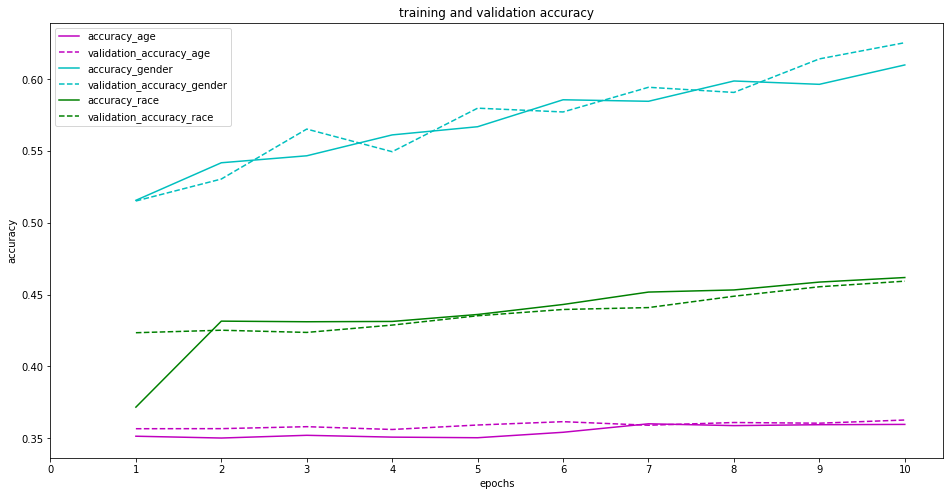

In [50]:
%%time
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
resnet34 = Net(net='resnet34', pretrained=False).to(device)
optimizer = optim.SGD(resnet34.parameters(), lr=1e-5, momentum = 0.9)
trainWithOptimizer(resnet34)

Epoch 1, loss: 3.136, val_loss: 2.616, acc_gender: 0.748, val_acc_gender: 0.813, acc_age: 0.431, val_acc_age: 0.512392, acc_race: 0.526471, val_acc_race: 0.612213
Epoch 2, loss: 2.356, val_loss: 2.411, acc_gender: 0.838, val_acc_gender: 0.843, acc_age: 0.562, val_acc_age: 0.539812, acc_race: 0.665260, val_acc_race: 0.654240
Epoch 3, loss: 2.044, val_loss: 2.272, acc_gender: 0.874, val_acc_gender: 0.840, acc_age: 0.625, val_acc_age: 0.562487, acc_race: 0.712930, val_acc_race: 0.678074
Epoch 4, loss: 1.825, val_loss: 2.244, acc_gender: 0.885, val_acc_gender: 0.854, acc_age: 0.659, val_acc_age: 0.572084, acc_race: 0.757013, val_acc_race: 0.677389
Epoch 5, loss: 1.659, val_loss: 2.175, acc_gender: 0.905, val_acc_gender: 0.852, acc_age: 0.704, val_acc_age: 0.575828, acc_race: 0.773887, val_acc_race: 0.701645
Epoch 6, loss: 1.527, val_loss: 2.149, acc_gender: 0.910, val_acc_gender: 0.861, acc_age: 0.730, val_acc_age: 0.576619, acc_race: 0.799831, val_acc_race: 0.705073
Epoch 7, loss: 1.389, 

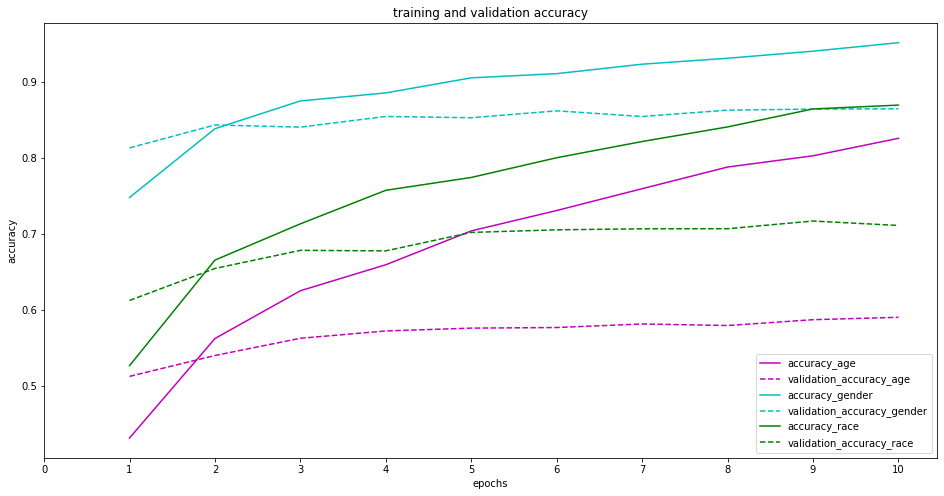

In [51]:
%%time
mobilenetv2 = Net(net='mobilenetv2').to(device)
optimizer = optim.SGD(mobilenetv2.parameters(), lr=1e-5, momentum = 0.9)
trainWithOptimizer(mobilenetv2)